# Imports and Configs

In [1]:
!pip install -q scikit-learn==1.4
!pip install -q --no-deps scikeras

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spaghetti 1.7.6 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.1 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import matthews_corrcoef
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import keras
import gc

warnings.filterwarnings('ignore')

2024-08-05 07:00:37.328173: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 07:00:37.328310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 07:00:37.517152: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
TARGET = 'class'
N_FOLDS = 5
SEED = 6

# Loading Data

In [4]:
train = pd.read_csv('/kaggle/input/playground-series-s4e8/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv', index_col='id')

In [5]:
train.shape, test.shape

((3116945, 21), (2077964, 20))

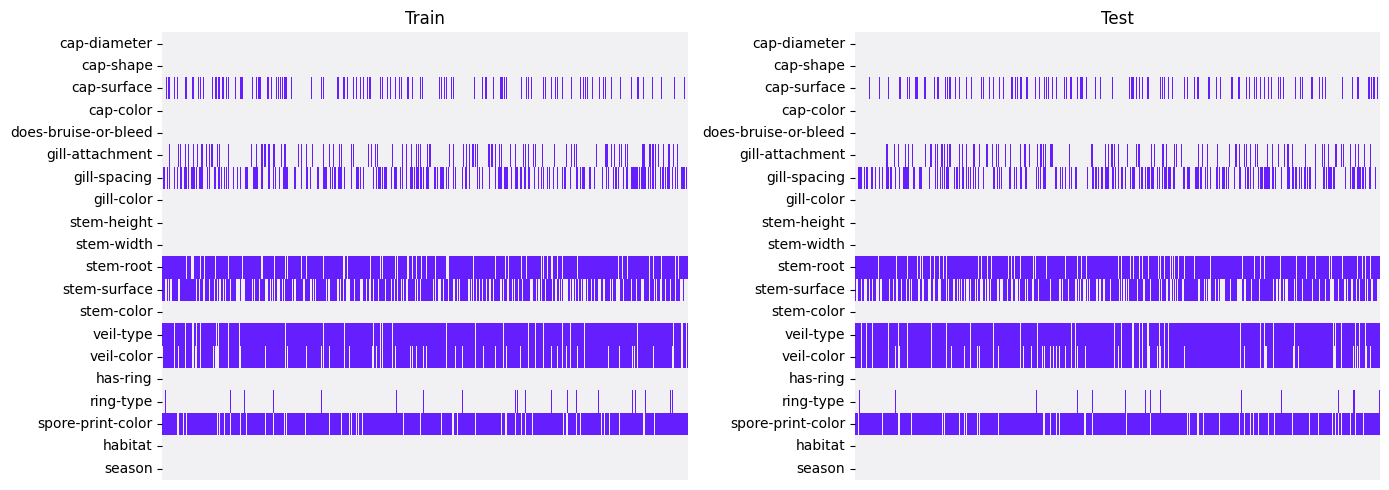

In [6]:
cmap = sns.light_palette('#651FFF', as_cmap=True)

train_null_values = train.sample(100_000).drop(columns=TARGET).isnull().T
test_null_values = test.sample(100_000).isnull().T

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

sns.heatmap(train_null_values, cbar=False, cmap=cmap, ax=axes[0])
axes[0].set_title('Train')
axes[0].set_xticks([]) 
axes[0].set_xlabel('')

sns.heatmap(test_null_values, cbar=False, cmap=cmap, ax=axes[1])
axes[1].set_title('Test')
axes[1].set_xticks([]) 
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

# Feature Engineering

In [7]:
cat_features = test.select_dtypes('object').columns
cont_features = test.select_dtypes('float').columns

In [8]:
for feature in cat_features:    
    for df in [train, test]:
        df.loc[df[feature].value_counts(dropna=False)[df[feature]].values < 100, feature] = 'rare'

In [9]:
one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='infrequent_if_exist', min_frequency=50)
step_1 = ('imputer', make_pipeline(PowerTransformer(), SimpleImputer(add_indicator=True)), cont_features)
step_2 = ('one-hot-encoder', one_hot_encoder, cat_features)
steps = [step_1, step_2]
transformer = ColumnTransformer(steps, remainder='passthrough')

pipeline = make_pipeline(transformer, StandardScaler())

In [10]:
X = train.drop([TARGET], axis=1)
y = train[TARGET].map({'e': 0, 'p': 1})
X_test = test

In [11]:
X = pipeline.fit_transform(X)
X_test = pipeline.transform(X_test)

# Training

In [12]:
class Trainer:
    def __init__(self, model, n_folds=N_FOLDS):
        self.model = model
        self.n_folds = n_folds

    def fit_predict(self, X, y, X_test):
        print(f'Training {self.model.__class__.__name__}\n')
        
        scores = []        
        oof_pred_probs = np.zeros((X.shape[0], len(np.unique(y))))
        test_pred_probs = np.zeros((X_test.shape[0], len(np.unique(y))))
        
        skf = StratifiedKFold(n_splits=self.n_folds, random_state=SEED, shuffle=True)
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            model = clone(self.model)
            model.fit(X_train, y_train)
            
            y_pred_probs = model.predict_proba(X_val)
            oof_pred_probs[val_idx] = y_pred_probs            
            
            temp_test_pred_probs = model.predict_proba(X_test)
            test_pred_probs += temp_test_pred_probs / self.n_folds
            
            score = matthews_corrcoef(y_val, np.argmax(y_pred_probs, axis=1))
            scores.append(score)
            
            del model, X_train, y_train, X_val, y_val, y_pred_probs
            gc.collect()
            
            print(f'\n--- Fold {fold_idx + 1} - MCC: {score:.6f}\n')            
            
        self._save_pred_probs(oof_pred_probs, np.mean(scores), 'oof')
        self._save_pred_probs(test_pred_probs, np.mean(scores), 'test')
        self._save_submission(test_pred_probs, np.mean(scores))
        print(f'\n\n------ Average MCC: {np.mean(scores):.6f} ± {np.std(scores):.6f}')
        
    def _save_pred_probs(self, pred_probs, cv_score, name):
        model_name = self.model.__class__.__name__.lower().replace('classifier', '')
        with open(f'{model_name}_{name}_pred_probs_{cv_score:.6f}.pkl', 'wb') as f:
            pickle.dump(pred_probs, f)
    
    def _save_submission(self, test_pred_probs, score):
        name = self.model.__class__.__name__.lower().replace('classifier', '')
        sub = pd.read_csv('/kaggle/input/playground-series-s4e8/sample_submission.csv')
        sub[TARGET] = np.argmax(test_pred_probs, axis=1)
        sub[TARGET] = sub[TARGET].map({0: 'e', 1: 'p'})
        sub.to_csv(f'sub_{name}_{score:.6f}.csv', index=False)

In [13]:
# Reference: https://www.kaggle.com/code/ambrosm/pss4e8-eda-which-makes-sense

def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta['X_shape_'][1:]))
    model.add(keras.layers.Dense(359, kernel_initializer='glorot_uniform', activation='selu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(431, kernel_initializer='glorot_uniform', activation='selu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(314, kernel_initializer='glorot_uniform', activation='selu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

model = KerasClassifier(
    get_model,
    loss='binary_crossentropy',
    optimizer=keras.optimizers.AdamW(learning_rate=0.0496),
    validation_split=0.05,
    batch_size=4096,
    validation_batch_size=65536,
    epochs=50,
    verbose=1,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=3),
        keras.callbacks.EarlyStopping(patience=5, min_delta=0.00003)
    ]
)

In [14]:
trainer = Trainer(model)
trainer.fit_predict(X, y, X_test)

Training KerasClassifier

Epoch 1/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 75s 125ms/step - loss: 11.0402 - val_loss: 0.0919 - learning_rate: 0.0496
Epoch 2/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - loss: 0.1011 - val_loss: 0.0541 - learning_rate: 0.0496
Epoch 3/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - loss: 0.0679 - val_loss: 0.0482 - learning_rate: 0.0496
Epoch 4/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - loss: 0.0575 - val_loss: 0.0462 - learning_rate: 0.0496
Epoch 5/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 65s 112ms/step - loss: 0.0519 - val_loss: 0.0438 - learning_rate: 0.0496
Epoch 6/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 82s 112ms/step - loss: 1.2976 - val_loss: 0.7043 - learning_rate: 0.0496
Epoch 7/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 66s 114ms/step - loss: 0.8749 - val_loss: 0.7024 - learning_rate: 0.0496
Epoch 8/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 65s 113ms/step - loss: 0.7811 - val_loss: 0.7491 - learning_rate: 0.0496
Epoch 9/50
579/579 ━━━━━━━━━━━━━━━━━━━━ 82s 113ms/step - loss: 0.6964